In [1]:
# Import necessary libraries
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Generate synthetic data with make_classification
X, y = make_classification(
    n_samples=3000,  # Number of samples
    n_features=4,     # Number of features
    n_informative=2,  # Number of informative features (features contributing to the target)
    n_redundant=0,    # Number of redundant features (linear combinations of informative features)
    n_clusters_per_class=1,  # Number of clusters per class
    random_state=34
)

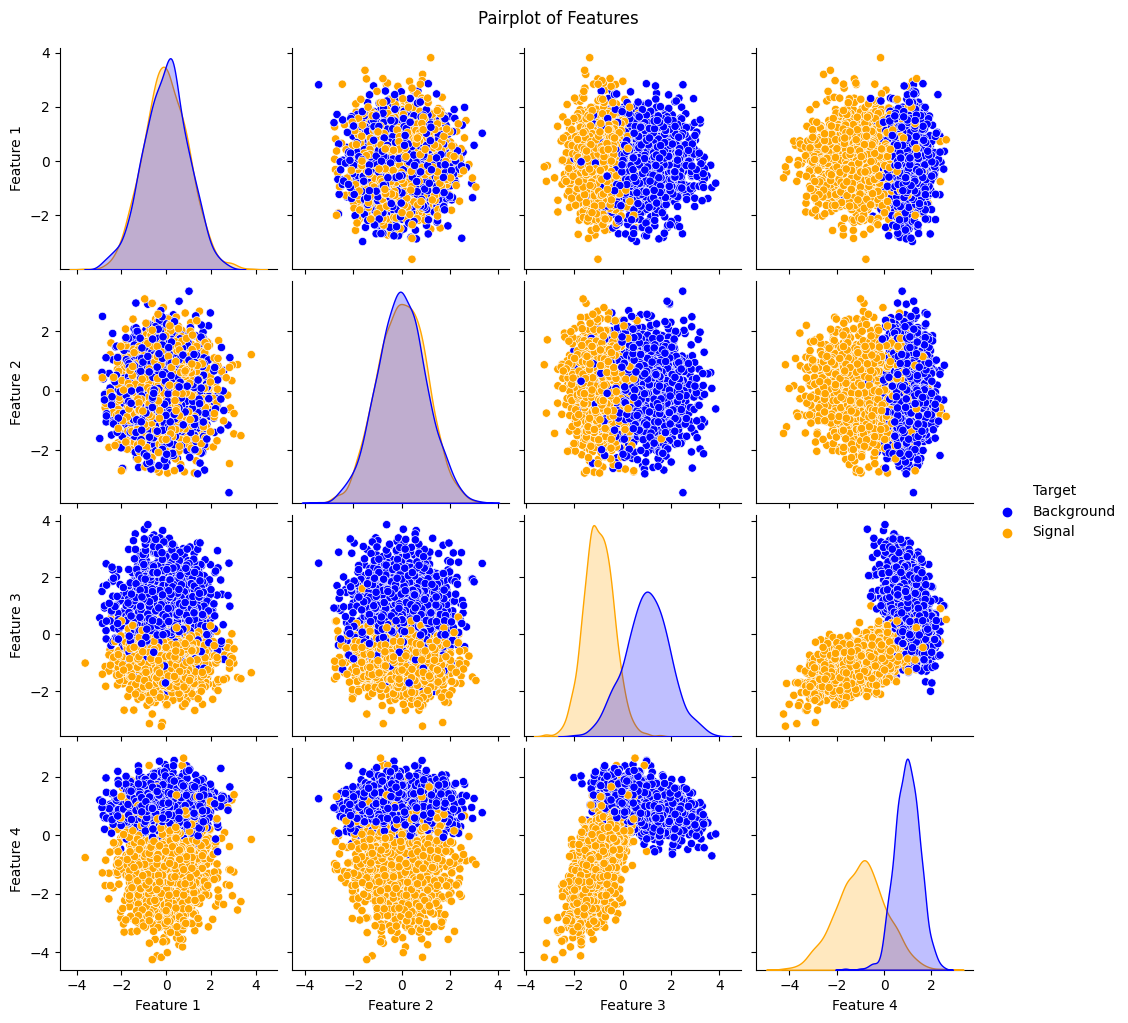

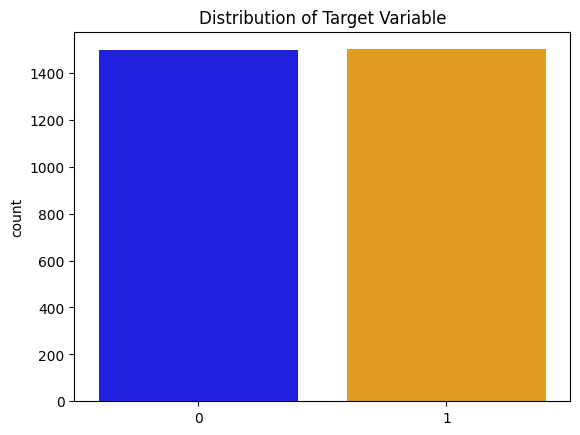

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.DataFrame(np.column_stack((X, y)), columns=[f'Feature {i+1}' for i in range(X.shape[1])] + ['Target'])
df['Target']='Background'
df.loc[y==1,'Target']='Signal'
df['Target'] = df['Target'].astype('category')

# Pairplot for visualizing relationships between features with color based on target variable
data_pairplot = sns.pairplot(
    data=df,
    hue='Target',
    palette={'Background': 'blue', 'Signal': 'orange'},
    height=2.5
)
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()

# Countplot for visualizing the distribution of the target variable with color
sns.countplot(x=y, palette={0: 'blue', 1: 'orange'})
plt.title('Distribution of Target Variable')
plt.show()


In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# default: max_depth=2, min_samples_split=2
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=20)
BDT = AdaBoostClassifier(estimator=DTC,n_estimators=150,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(X_train, y_train) # BDT looks at each feature independently, so scaling is typically not necessary

# BDT scores
y_prob_test = model.decision_function(X_test)
# Prediction
y_pred_test = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy: {accuracy * 100:.3f}%")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 93.000%
Confusion Matrix:
[[281  25]
 [ 17 277]]


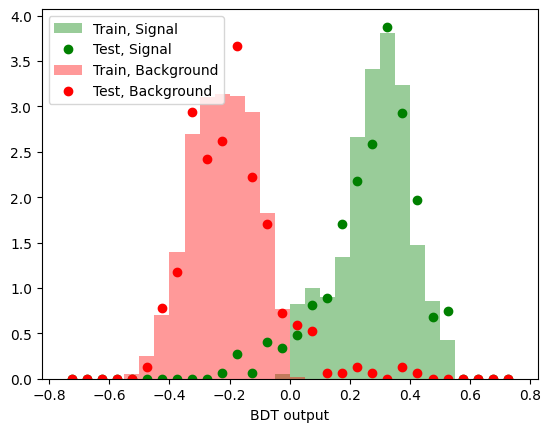

In [4]:
# Extract decision function outputs for signal and background classes in the training set
y_pred_signal_train = model.decision_function(X_train[y_train==1])
y_pred_signal_test = model.decision_function(X_test[y_test==1])
y_pred_background_train = model.decision_function(X_train[y_train==0])
y_pred_background_test = model.decision_function(X_test[y_test==0])

# Set the number of bins, range, and other parameters for the histogram
n_bins = 30
hist_range = (-.75, .75)

# Plot histogram for the signal class in the training set
plt.hist(y_pred_signal_train, bins=n_bins, range=hist_range, density=True, alpha=0.4, color='green', label="Train, Signal")

# Plot histogram for the signal class in the test set
counts, bin_edges = np.histogram(y_pred_signal_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color='green', label="Test, Signal")

# Plot histogram for the background class in the training set
plt.hist(y_pred_background_train, bins=n_bins, range=hist_range, density=True, alpha=0.4, color='red', label="Train, Background")

# Plot histogram for the background class in the test set
counts, bin_edges = np.histogram(y_pred_background_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color='red', label="Test, Background")

# Add legend and labels to the plot
plt.legend()
plt.xlabel('BDT output')
#plt.yscale('log')

# Show the plot
plt.show()

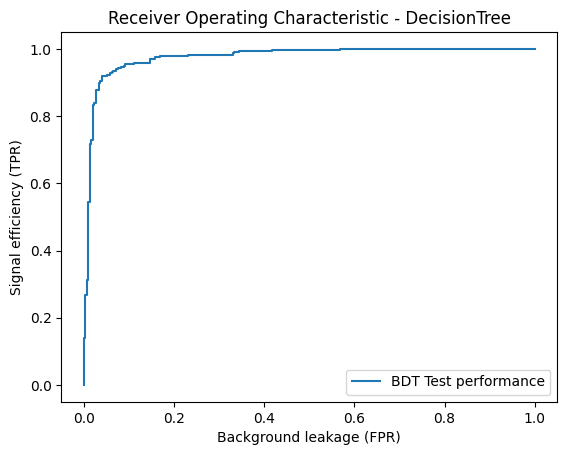

In [5]:
from sklearn.metrics import roc_curve
# Compute ROC curve for the Boosted Decision Tree (BDT) model using the test set
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_prob_test, pos_label=1)

# Plot the ROC curve for the BDT model
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT Test performance")

# Add title and axis labels to the plot
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

# Add legend to the plot
plt.legend(loc="lower right")

# Show the plot
plt.show()

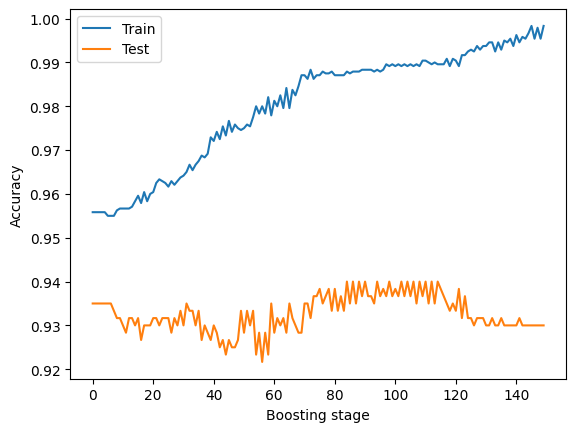

In [6]:
# Initialize empty lists to store training and testing accuracy at each boosting stage
test_acc, train_acc = [], []

# Iterate through each boosting stage and collect accuracy scores for training set predictions
for train_predict in model.staged_predict(X_train):
    train_acc.append(accuracy_score(train_predict, y_train))
    
# Iterate through each boosting stage and collect accuracy scores for test set predictions
for test_predict in model.staged_predict(X_test):
    test_acc.append(accuracy_score(test_predict, y_test)) 

# Plot the training and testing accuracy over boosting stages
plt.plot(train_acc, label="Train")  # Plot training accuracy
plt.plot(test_acc, label="Test")    # Plot testing accuracy
plt.xlabel("Boosting stage")         # Label for the x-axis
plt.ylabel("Accuracy")               # Label for the y-axis
plt.legend()                         # Add legend to distinguish between training and testing accuracy
plt.show()


[0.98934044] [0.02001334] [-0.0107684]


/var/folders/h1/s46zdkz905j6q1vd7vxjj6v40000gn/T/ipykernel_45310/3129644868.py:20: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)


<Figure size 500x500 with 0 Axes>

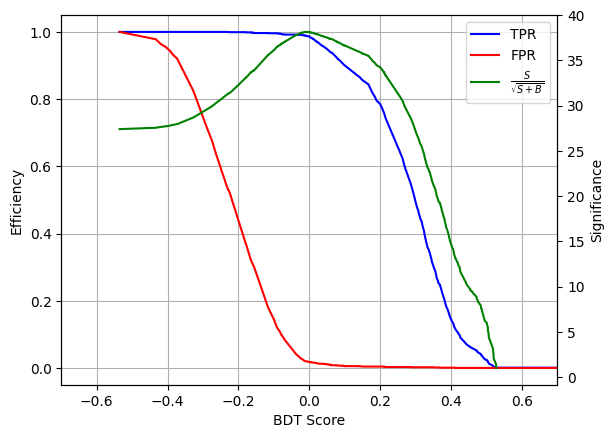

In [7]:
# Obtain decision function scores for all samples in the dataset
y_predict = model.decision_function(X)

# Extract true labels from the dataset
y_data = y

# Determine the event sizes for signal and background classes
signal_eventsize = len(X[y == 1])
background_eventsize = len(X[y == 0]) 

# Compute ROC curves for both signal and background classes
signal_FPR, signal_TPR, signal_BDT_Score = roc_curve(y_data, y_predict, pos_label=1)  # Signal class set to 1
background_FPR, background_TPR, background_BDT_Score = roc_curve(y_data, y_predict, pos_label=0)  # Background class set to 0

# Calculate the Signal (S) and Background (B) contributions for significance metric
S = signal_eventsize * signal_TPR
B = background_eventsize * signal_FPR

# Calculate the significance metric S / sqrt(S + B) at each BDT score
metric = S / np.sqrt(S + B)

# Find the maximum significance and corresponding signal and background efficiencies and BDT score cut
max_metric = np.nanmax(metric)
signal_eff_max_metric = signal_TPR[np.where(metric == np.nanmax(metric))]
background_eff_max_metric = signal_FPR[np.where(metric == np.nanmax(metric))]
score_cut = signal_BDT_Score[np.where(metric == np.nanmax(metric))]

# Print the results
print(signal_eff_max_metric, background_eff_max_metric, score_cut)

# Create a plot to visualize the ROC curve, signal and background efficiencies, and significance metric
plt.figure(figsize=(5, 5))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel('BDT Score')
ax1.set_ylabel('Efficiency')
ax2.set_ylabel('Significance')

# Plot the True Positive Rate (TPR) and False Positive Rate (FPR) on the left y-axis
lns1 = ax1.plot(signal_BDT_Score, signal_TPR, 'b-', label="TPR")
lns2 = ax1.plot(signal_BDT_Score, signal_FPR, 'r-', label="FPR")

# Plot the significance metric on the right y-axis
lns3 = ax2.plot(signal_BDT_Score, metric, 'g-', label='$\\frac{S}{\\sqrt{S+B}}$')

# Add gridlines to the plot
ax1.grid()

# Combine all lines and labels for legend
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

# Set x-axis limits for better visualization
plt.xlim(-0.7, 0.7)

# Display the plot
plt.show()

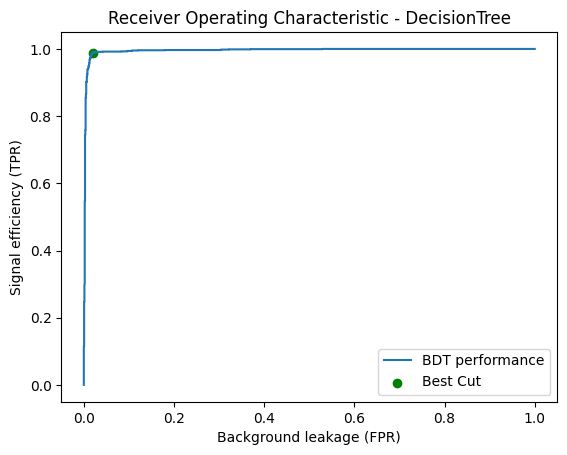

In [8]:
# Obtain decision function scores for all samples in the dataset
Y_prob_all = model.decision_function(X)

# Compute ROC curve for the Boosted Decision Tree (BDT) model using the entire dataset
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y, Y_prob_all, pos_label=1)  # Signal class set to 1

# Plot the ROC curve for the BDT model
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")

# Scatter plot to highlight the point corresponding to the best cut (maximized significance)
plt.scatter(background_eff_max_metric, signal_eff_max_metric, c='green', label="Best Cut")

# Add title and axis labels to the plot
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

# Add legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

# Homework
The data below contains 3000 events for 8 different values. 6 of them are relative to each other and this makes them informative variable. Using this data;
- Draw distribution of variables (see second cell)
- Perform Decision Tree Analysis and show your finding ROC, Accuracy, etc.
- Perform Boosted Decision Tree Analysis and show your finding ROC, Accuracy, etc. (Like in cells between (1-8))
- Compare the DT and BDT results and comment on your findings

In [9]:
# Generate synthetic data with make_classification
X, y = make_classification(
    n_samples=3000,  # Number of samples
    n_features=8,     # Number of features
    n_informative=6,  # Number of informative features (features contributing to the target)
    n_redundant=0,    # Number of redundant features (linear combinations of informative features)
    n_clusters_per_class=1,  # Number of clusters per class
    random_state=42
)